In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
from lassolver.utils.func import *
from lassolver.utils.signal import *
from lassolver.utils.utils import *

from lassolver.matrices.iid_gauss import iidGaussian
from lassolver.matrices.uni_invar import UniInvar

from lassolver.solver.amp import AMP
from lassolver.solver.oamp import OAMP

from lassolver.dsolver.d_amp import D_AMP
from lassolver.dsolver.d_oamp import D_OAMP

# 条件数の増加に対する疎信号再構成の性能比較

In [4]:
N = 500  # 列数
alpha = 0.5  # 圧縮率
M = int(alpha*N)  # 行数
rho = 0.2  # 非零成分の割合

In [7]:
SNR = 60  # 信号対雑音比
P = 10  # ノード数
T = 50  # 反復回数
sim = int(1e+6)  # 範囲
realization = 100  # 実験数
judge = [1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000, 500000, 1000000]  # 実験を行う回

In [8]:
MSE_oamp = np.zeros((2, realization, sim))
MSE_doamp = np.zeros((2, realization, sim))
MSE_doamp_approx = np.zeros((2, realization, sim))

In [9]:
lenj = len(judge)
CommCost_doamp = np.empty((2, lenj, realization, T))
CommCost_doamp_approx = np.empty((2, lenj, realization, T))

In [10]:
for i in tqdm(range(realization)):
  x = bernouli_gaussian(N, rho)
  UniInv = UniInvar(M, N, 1)
  count = 0

  for j in range(sim):
    kappa = j+1
    if kappa not in judge: continue

    UniInv.change_cond(kappa)
    oamp = [0, 0]
    doamp = [0, 0]
    doamp_approx = [0, 0]

    for k in range(2):
      oamp[k] = OAMP(UniInv.A, x, SNR)
      doamp[k] = D_OAMP(UniInv.A, x, SNR, P)
      doamp_approx[k] = D_OAMP(UniInv.A, x, SNR, P)

    oamp[0].estimate(T=T, ord='PINV')
    oamp[1].estimate(T=T, ord='LMMSE')
    doamp[0].estimate(T=T, C=1.9, ord='PINV')
    doamp[1].estimate(T=T, C=1.9, ord='LMMSE')
    doamp_approx[0].estimate(T=T, C=1.9, ord='PINV', approx=True)
    doamp_approx[1].estimate(T=T, C=1.9, ord='LMMSE', approx=True)

    for k in range(2):
      MSE_oamp[k, i, j] = oamp[k].mse[-1]
      MSE_doamp[k, i, j] = doamp[k].mse[-1]
      MSE_doamp_approx[k, i, j] = doamp_approx[k].mse[-1]

      CommCost_doamp[k, count, i] = doamp[k].communication_cost
      CommCost_doamp_approx[k, count, i] = doamp_approx[k].communication_cost

    count += 1

100%|██████████| 2/2 [12:37<00:00, 378.56s/it]


In [11]:
mean_MSE_oamp = np.empty((2, sim))
mean_MSE_doamp = np.empty((2, sim))
mean_MSE_doamp_approx = np.empty((2, sim))

In [12]:
for i in range(2):
  mean_MSE_oamp[i] = np.mean(MSE_oamp[i], axis=0)
  mean_MSE_doamp[i] = np.mean(MSE_doamp[i], axis=0)
  mean_MSE_doamp_approx[i] = np.mean(MSE_doamp_approx[i], axis=0)

In [13]:
for i in range(2):
  for j in tqdm(range(sim)):
    if mean_MSE_oamp[i, j] == 0:
      mean_MSE_oamp[i, j] = None
    if mean_MSE_doamp[i, j] == 0:
      mean_MSE_doamp[i, j] = None
    if mean_MSE_doamp_approx[i, j] == 0:
      mean_MSE_doamp_approx[i, j] = None

100%|██████████| 1000000/1000000 [00:02<00:00, 344525.69it/s]


In [14]:
mean_CommCost_doamp = np.empty((2, lenj, T))
mean_CommCost_doamp_approx = np.empty((2, lenj, T))

In [15]:
for i in range(2):
  for j in range(lenj):
    mean_CommCost_doamp[i, j] = np.mean(CommCost_doamp[i, j], axis=0)
    mean_CommCost_doamp_approx[i, j] = np.mean(CommCost_doamp_approx[i, j], axis=0)

# MSE

## OAMPの場合

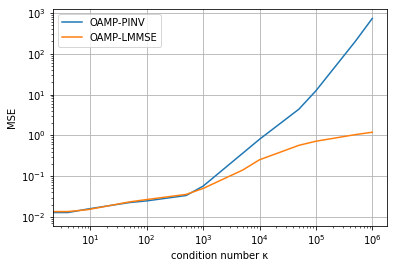

In [41]:
it = np.arange(0, sim, 1)

plt.xlabel('condition number κ')
plt.ylabel('MSE')
plt.xscale('log')
plt.yscale('log')

sp = mean_MSE_oamp[0].astype(np.double)
mp = np.isfinite(sp)

sl = mean_MSE_oamp[1].astype(np.double)
ml = np.isfinite(sl)

plt.plot(it[mp], sp[mp], label='OAMP-PINV')
plt.plot(it[ml], sl[ml], label='OAMP-LMMSE')

plt.legend()
plt.grid()

## D-OAMP(近似なし)の場合

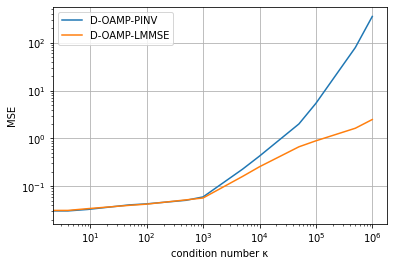

In [42]:
plt.xlabel('condition number κ')
plt.ylabel('MSE')
plt.xscale('log')
plt.yscale('log')

sdp = mean_MSE_doamp[0].astype(np.double)
mdp = np.isfinite(sdp)

sdl = mean_MSE_doamp[1].astype(np.double)
mdl = np.isfinite(sdl)

plt.plot(it[mdp], sdp[mdp], label='D-OAMP-PINV')
plt.plot(it[mdl], sdl[mdl], label='D-OAMP-LMMSE')

plt.legend()
plt.grid()

## D-OAMP(近似あり)の場合

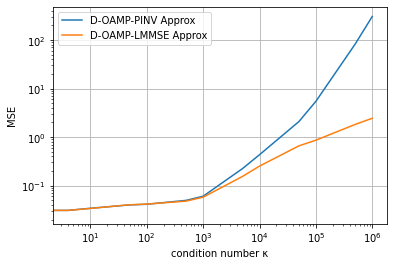

In [43]:
plt.xlabel('condition number κ')
plt.ylabel('MSE')
plt.xscale('log')
plt.yscale('log')

sdpX = mean_MSE_doamp_approx[0].astype(np.double)
mdpX = np.isfinite(sdpX)

sdlX = mean_MSE_doamp_approx[1].astype(np.double)
mdlX = np.isfinite(sdlX)

plt.plot(it[mdpX], sdpX[mdpX], label='D-OAMP-PINV Approx')
plt.plot(it[mdlX], sdlX[mdlX], label='D-OAMP-LMMSE Approx')

plt.legend()
plt.grid()

## すべて

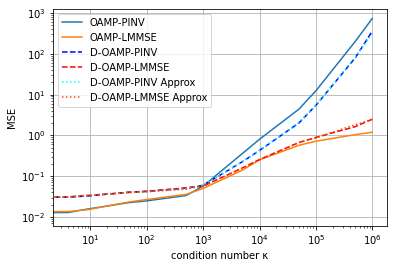

In [49]:
plt.xlabel('condition number κ')
plt.ylabel('MSE')
plt.xscale('log')
plt.yscale('log')

plt.plot(it[mp], sp[mp], label='OAMP-PINV')
plt.plot(it[ml], sl[ml], label='OAMP-LMMSE')
plt.plot(it[mdp], sdp[mdp], linestyle='--', color='b', label='D-OAMP-PINV')
plt.plot(it[mdl], sdl[mdl], linestyle='--', color='r', label='D-OAMP-LMMSE')
plt.plot(it[mdpX], sdpX[mdpX], linestyle=':', color='aqua', label='D-OAMP-PINV Approx')
plt.plot(it[mdlX], sdlX[mdlX], linestyle=':', color='orangered', label='D-OAMP-LMMSE Approx')

plt.legend()
plt.grid()

## OAMPとD-OAMP(近似なし)

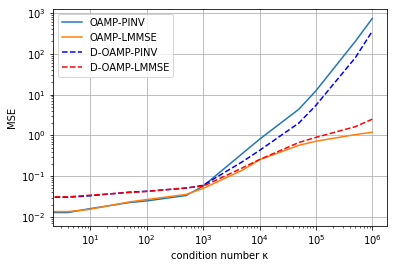

In [50]:
plt.xlabel('condition number κ')
plt.ylabel('MSE')
plt.xscale('log')
plt.yscale('log')

plt.plot(it[mp], sp[mp], label='OAMP-PINV')
plt.plot(it[ml], sl[ml], label='OAMP-LMMSE')
plt.plot(it[mdp], sdp[mdp], linestyle='--', color='b', label='D-OAMP-PINV')
plt.plot(it[mdl], sdl[mdl], linestyle='--', color='r', label='D-OAMP-LMMSE')

plt.legend()
plt.grid()

## D-OAMP(近似なし)とD-OAMP(近似あり)

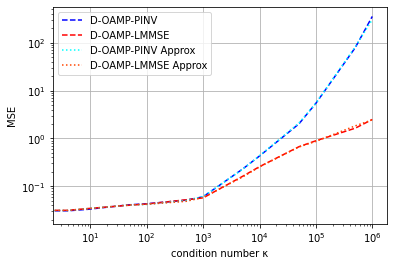

In [51]:
plt.xlabel('condition number κ')
plt.ylabel('MSE')
plt.xscale('log')
plt.yscale('log')

plt.plot(it[mdp], sdp[mdp], linestyle='--', color='b', label='D-OAMP-PINV')
plt.plot(it[mdl], sdl[mdl], linestyle='--', color='r', label='D-OAMP-LMMSE')
plt.plot(it[mdpX], sdpX[mdpX], linestyle=':', color='aqua', label='D-OAMP-PINV Approx')
plt.plot(it[mdlX], sdlX[mdlX], linestyle=':', color='orangered', label='D-OAMP-LMMSE Approx')

plt.legend()
plt.grid()

# 通信量

In [17]:
ix2 = np.arange(0, T, 5)
it2 = np.arange(0, T, 1)

standard = np.array([N * (P - 1) for _ in range(T)])

## D-OAMP(近似なし)の場合

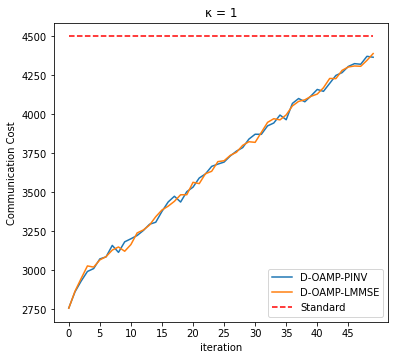

In [19]:
plt.figure(figsize=(6, 5.5))

plt.title('κ = 1')
plt.xlabel('iteration')
plt.ylabel('Communication Cost')

plt.xticks(ix2)

plt.plot(it2, mean_CommCost_doamp[0, 0], label='D-OAMP-PINV')
plt.plot(it2, mean_CommCost_doamp[1, 0], label='D-OAMP-LMMSE')
plt.plot(it2, standard, ls='--', color='r', label='Standard')

plt.legend()

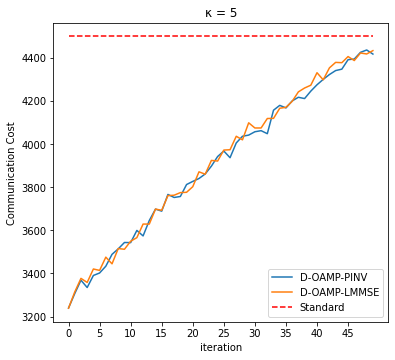

In [20]:
plt.figure(figsize=(6, 5.5))

plt.title('κ = 5')
plt.xlabel('iteration')
plt.ylabel('Communication Cost')

plt.xticks(ix2)

plt.plot(it2, mean_CommCost_doamp[0, 1], label='D-OAMP-PINV')
plt.plot(it2, mean_CommCost_doamp[1, 1], label='D-OAMP-LMMSE')
plt.plot(it2, standard, ls='--', color='r', label='Standard')

plt.legend()

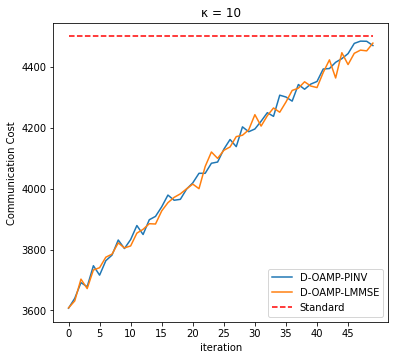

In [21]:
plt.figure(figsize=(6, 5.5))

plt.title('κ = 10')
plt.xlabel('iteration')
plt.ylabel('Communication Cost')

plt.xticks(ix2)

plt.plot(it2, mean_CommCost_doamp[0, 2], label='D-OAMP-PINV')
plt.plot(it2, mean_CommCost_doamp[1, 2], label='D-OAMP-LMMSE')
plt.plot(it2, standard, ls='--', color='r', label='Standard')

plt.legend()

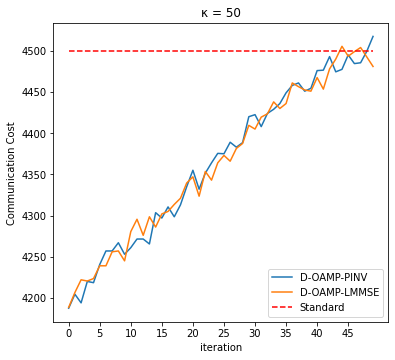

In [22]:
plt.figure(figsize=(6, 5.5))

plt.title('κ = 50')
plt.xlabel('iteration')
plt.ylabel('Communication Cost')

plt.xticks(ix2)

plt.plot(it2, mean_CommCost_doamp[0, 3], label='D-OAMP-PINV')
plt.plot(it2, mean_CommCost_doamp[1, 3], label='D-OAMP-LMMSE')
plt.plot(it2, standard, ls='--', color='r', label='Standard')

plt.legend()

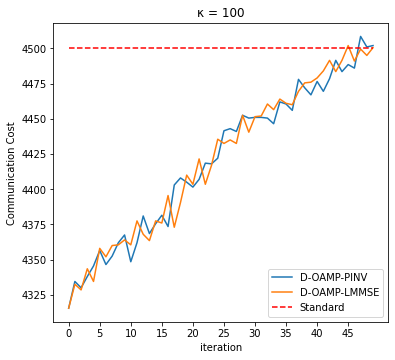

In [23]:
plt.figure(figsize=(6, 5.5))

plt.title('κ = 100')
plt.xlabel('iteration')
plt.ylabel('Communication Cost')

plt.xticks(ix2)

plt.plot(it2, mean_CommCost_doamp[0, 4], label='D-OAMP-PINV')
plt.plot(it2, mean_CommCost_doamp[1, 4], label='D-OAMP-LMMSE')
plt.plot(it2, standard, ls='--', color='r', label='Standard')

plt.legend()

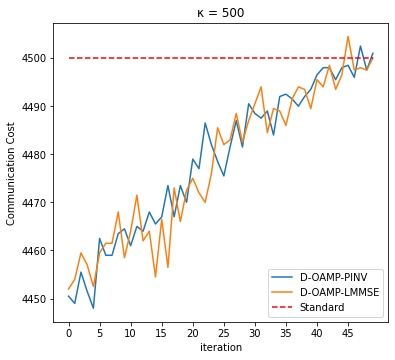

In [24]:
plt.figure(figsize=(6, 5.5))

plt.title('κ = 500')
plt.xlabel('iteration')
plt.ylabel('Communication Cost')

plt.xticks(ix2)

plt.plot(it2, mean_CommCost_doamp[0, 5], label='D-OAMP-PINV')
plt.plot(it2, mean_CommCost_doamp[1, 5], label='D-OAMP-LMMSE')
plt.plot(it2, standard, ls='--', color='r', label='Standard')

plt.legend()

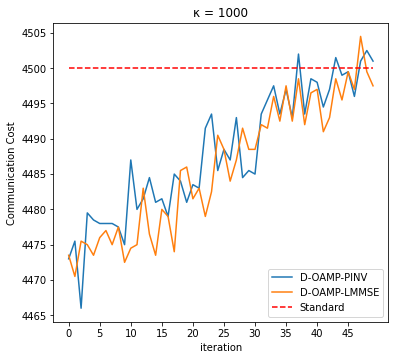

In [25]:
plt.figure(figsize=(6, 5.5))

plt.title('κ = 1000')
plt.xlabel('iteration')
plt.ylabel('Communication Cost')

plt.xticks(ix2)

plt.plot(it2, mean_CommCost_doamp[0, 6], label='D-OAMP-PINV')
plt.plot(it2, mean_CommCost_doamp[1, 6], label='D-OAMP-LMMSE')
plt.plot(it2, standard, ls='--', color='r', label='Standard')

plt.legend()

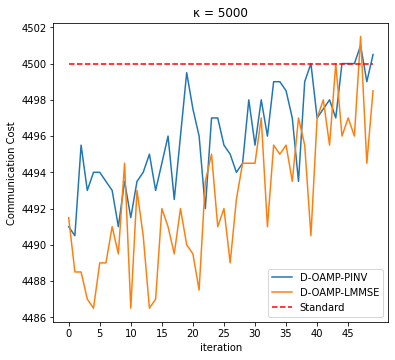

In [26]:
plt.figure(figsize=(6, 5.5))

plt.title('κ = 5000')
plt.xlabel('iteration')
plt.ylabel('Communication Cost')

plt.xticks(ix2)

plt.plot(it2, mean_CommCost_doamp[0, 7], label='D-OAMP-PINV')
plt.plot(it2, mean_CommCost_doamp[1, 7], label='D-OAMP-LMMSE')
plt.plot(it2, standard, ls='--', color='r', label='Standard')

plt.legend()

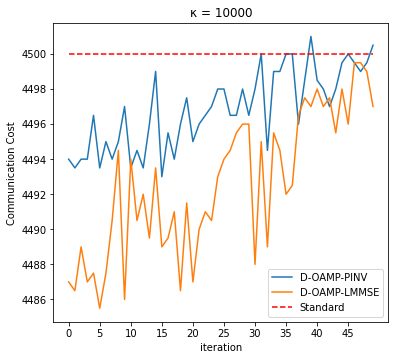

In [27]:
plt.figure(figsize=(6, 5.5))

plt.title('κ = 10000')
plt.xlabel('iteration')
plt.ylabel('Communication Cost')

plt.xticks(ix2)

plt.plot(it2, mean_CommCost_doamp[0, 8], label='D-OAMP-PINV')
plt.plot(it2, mean_CommCost_doamp[1, 8], label='D-OAMP-LMMSE')
plt.plot(it2, standard, ls='--', color='r', label='Standard')

plt.legend()

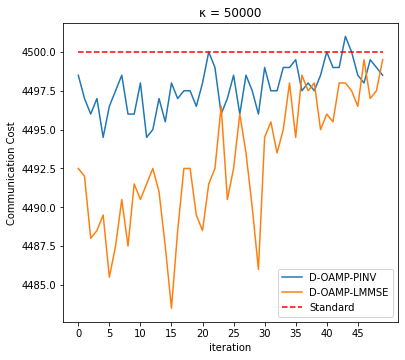

In [28]:
plt.figure(figsize=(6, 5.5))

plt.title('κ = 50000')
plt.xlabel('iteration')
plt.ylabel('Communication Cost')

plt.xticks(ix2)

plt.plot(it2, mean_CommCost_doamp[0, 9], label='D-OAMP-PINV')
plt.plot(it2, mean_CommCost_doamp[1, 9], label='D-OAMP-LMMSE')
plt.plot(it2, standard, ls='--', color='r', label='Standard')

plt.legend()

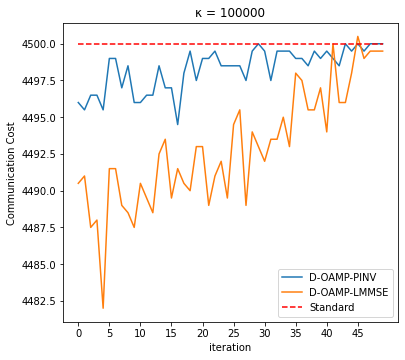

In [29]:
plt.figure(figsize=(6, 5.5))

plt.title('κ = 100000')
plt.xlabel('iteration')
plt.ylabel('Communication Cost')

plt.xticks(ix2)

plt.plot(it2, mean_CommCost_doamp[0, 10], label='D-OAMP-PINV')
plt.plot(it2, mean_CommCost_doamp[1, 10], label='D-OAMP-LMMSE')
plt.plot(it2, standard, ls='--', color='r', label='Standard')

plt.legend()

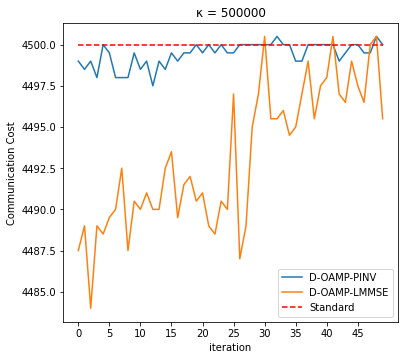

In [30]:
plt.figure(figsize=(6, 5.5))

plt.title('κ = 500000')
plt.xlabel('iteration')
plt.ylabel('Communication Cost')

plt.xticks(ix2)

plt.plot(it2, mean_CommCost_doamp[0, 11], label='D-OAMP-PINV')
plt.plot(it2, mean_CommCost_doamp[1, 11], label='D-OAMP-LMMSE')
plt.plot(it2, standard, ls='--', color='r', label='Standard')

plt.legend()

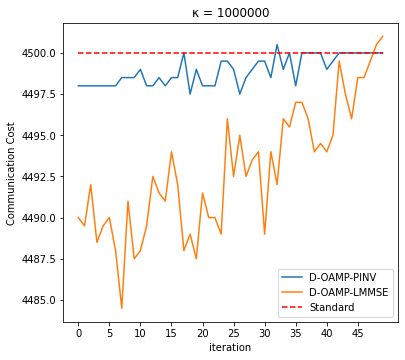

In [31]:
plt.figure(figsize=(6, 5.5))

plt.title('κ = 1000000')
plt.xlabel('iteration')
plt.ylabel('Communication Cost')

plt.xticks(ix2)

plt.plot(it2, mean_CommCost_doamp[0, 12], label='D-OAMP-PINV')
plt.plot(it2, mean_CommCost_doamp[1, 12], label='D-OAMP-LMMSE')
plt.plot(it2, standard, ls='--', color='r', label='Standard')

plt.legend()

## D-OAMP(近似あり)の場合

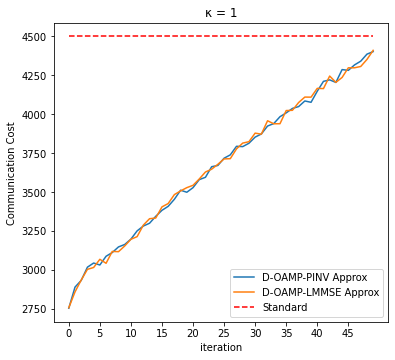

In [32]:
plt.figure(figsize=(6, 5.5))

plt.title('κ = 1')
plt.xlabel('iteration')
plt.ylabel('Communication Cost')

plt.xticks(ix2)

plt.plot(it2, mean_CommCost_doamp_approx[0, 0], label='D-OAMP-PINV Approx')
plt.plot(it2, mean_CommCost_doamp_approx[1, 0], label='D-OAMP-LMMSE Approx')
plt.plot(it2, standard, ls='--', color='r', label='Standard')

plt.legend()

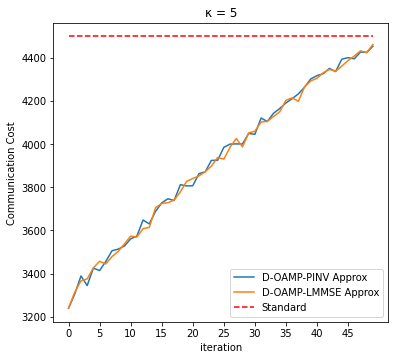

In [33]:
plt.figure(figsize=(6, 5.5))

plt.title('κ = 5')
plt.xlabel('iteration')
plt.ylabel('Communication Cost')

plt.xticks(ix2)

plt.plot(it2, mean_CommCost_doamp_approx[0, 1], label='D-OAMP-PINV Approx')
plt.plot(it2, mean_CommCost_doamp_approx[1, 1], label='D-OAMP-LMMSE Approx')
plt.plot(it2, standard, ls='--', color='r', label='Standard')

plt.legend()

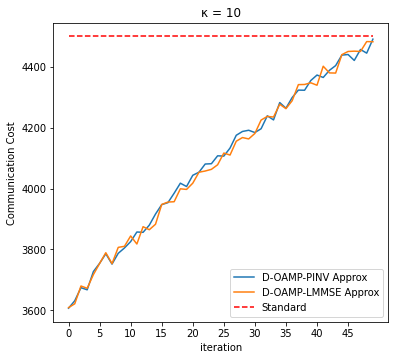

In [34]:
plt.figure(figsize=(6, 5.5))

plt.title('κ = 10')
plt.xlabel('iteration')
plt.ylabel('Communication Cost')

plt.xticks(ix2)

plt.plot(it2, mean_CommCost_doamp_approx[0, 2], label='D-OAMP-PINV Approx')
plt.plot(it2, mean_CommCost_doamp_approx[1, 2], label='D-OAMP-LMMSE Approx')
plt.plot(it2, standard, ls='--', color='r', label='Standard')

plt.legend()

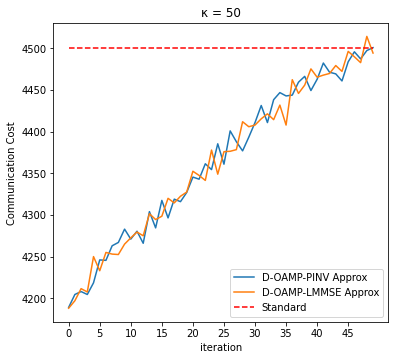

In [35]:
plt.figure(figsize=(6, 5.5))

plt.title('κ = 50')
plt.xlabel('iteration')
plt.ylabel('Communication Cost')

plt.xticks(ix2)

plt.plot(it2, mean_CommCost_doamp_approx[0, 3], label='D-OAMP-PINV Approx')
plt.plot(it2, mean_CommCost_doamp_approx[1, 3], label='D-OAMP-LMMSE Approx')
plt.plot(it2, standard, ls='--', color='r', label='Standard')

plt.legend()

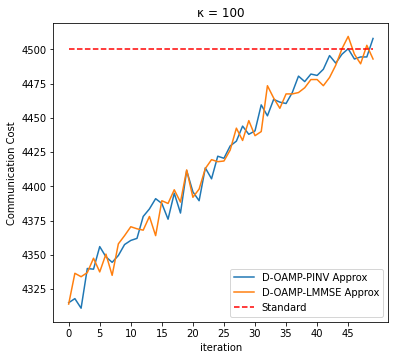

In [36]:
plt.figure(figsize=(6, 5.5))

plt.title('κ = 100')
plt.xlabel('iteration')
plt.ylabel('Communication Cost')

plt.xticks(ix2)

plt.plot(it2, mean_CommCost_doamp_approx[0, 4], label='D-OAMP-PINV Approx')
plt.plot(it2, mean_CommCost_doamp_approx[1, 4], label='D-OAMP-LMMSE Approx')
plt.plot(it2, standard, ls='--', color='r', label='Standard')

plt.legend()

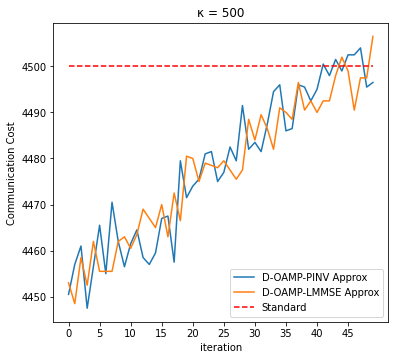

In [37]:
plt.figure(figsize=(6, 5.5))

plt.title('κ = 500')
plt.xlabel('iteration')
plt.ylabel('Communication Cost')

plt.xticks(ix2)

plt.plot(it2, mean_CommCost_doamp_approx[0, 5], label='D-OAMP-PINV Approx')
plt.plot(it2, mean_CommCost_doamp_approx[1, 5], label='D-OAMP-LMMSE Approx')
plt.plot(it2, standard, ls='--', color='r', label='Standard')

plt.legend()

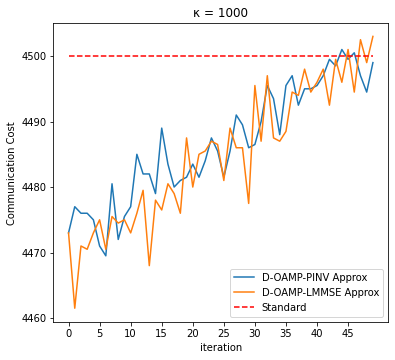

In [38]:
plt.figure(figsize=(6, 5.5))

plt.title('κ = 1000')
plt.xlabel('iteration')
plt.ylabel('Communication Cost')

plt.xticks(ix2)

plt.plot(it2, mean_CommCost_doamp_approx[0, 6], label='D-OAMP-PINV Approx')
plt.plot(it2, mean_CommCost_doamp_approx[1, 6], label='D-OAMP-LMMSE Approx')
plt.plot(it2, standard, ls='--', color='r', label='Standard')

plt.legend()

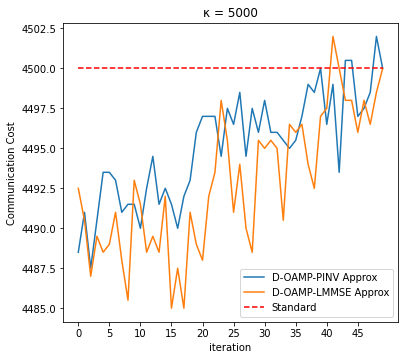

In [39]:
plt.figure(figsize=(6, 5.5))

plt.title('κ = 5000')
plt.xlabel('iteration')
plt.ylabel('Communication Cost')

plt.xticks(ix2)

plt.plot(it2, mean_CommCost_doamp_approx[0, 7], label='D-OAMP-PINV Approx')
plt.plot(it2, mean_CommCost_doamp_approx[1, 7], label='D-OAMP-LMMSE Approx')
plt.plot(it2, standard, ls='--', color='r', label='Standard')

plt.legend()

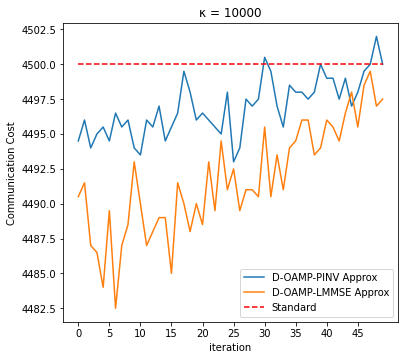

In [40]:
plt.figure(figsize=(6, 5.5))

plt.title('κ = 10000')
plt.xlabel('iteration')
plt.ylabel('Communication Cost')

plt.xticks(ix2)

plt.plot(it2, mean_CommCost_doamp_approx[0, 8], label='D-OAMP-PINV Approx')
plt.plot(it2, mean_CommCost_doamp_approx[1, 8], label='D-OAMP-LMMSE Approx')
plt.plot(it2, standard, ls='--', color='r', label='Standard')

plt.legend()

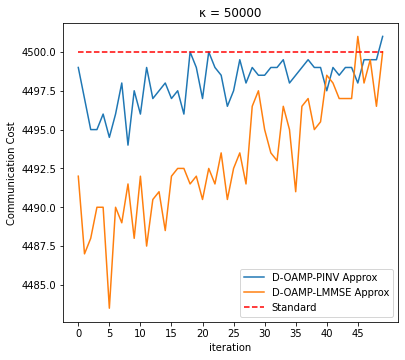

In [41]:
plt.figure(figsize=(6, 5.5))

plt.title('κ = 50000')
plt.xlabel('iteration')
plt.ylabel('Communication Cost')

plt.xticks(ix2)

plt.plot(it2, mean_CommCost_doamp_approx[0, 9], label='D-OAMP-PINV Approx')
plt.plot(it2, mean_CommCost_doamp_approx[1, 9], label='D-OAMP-LMMSE Approx')
plt.plot(it2, standard, ls='--', color='r', label='Standard')

plt.legend()

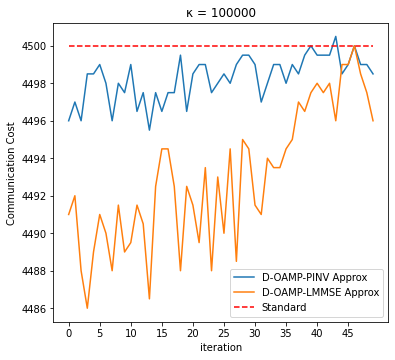

In [42]:
plt.figure(figsize=(6, 5.5))

plt.title('κ = 100000')
plt.xlabel('iteration')
plt.ylabel('Communication Cost')

plt.xticks(ix2)

plt.plot(it2, mean_CommCost_doamp_approx[0, 10], label='D-OAMP-PINV Approx')
plt.plot(it2, mean_CommCost_doamp_approx[1, 10], label='D-OAMP-LMMSE Approx')
plt.plot(it2, standard, ls='--', color='r', label='Standard')

plt.legend()

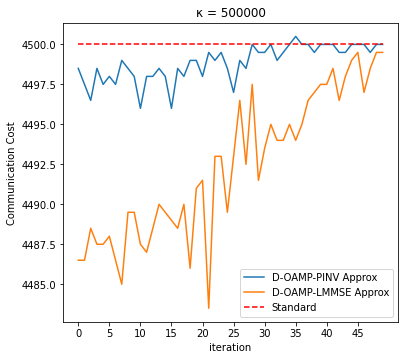

In [43]:
plt.figure(figsize=(6, 5.5))

plt.title('κ = 500000')
plt.xlabel('iteration')
plt.ylabel('Communication Cost')

plt.xticks(ix2)

plt.plot(it2, mean_CommCost_doamp_approx[0, 11], label='D-OAMP-PINV Approx')
plt.plot(it2, mean_CommCost_doamp_approx[1, 11], label='D-OAMP-LMMSE Approx')
plt.plot(it2, standard, ls='--', color='r', label='Standard')

plt.legend()

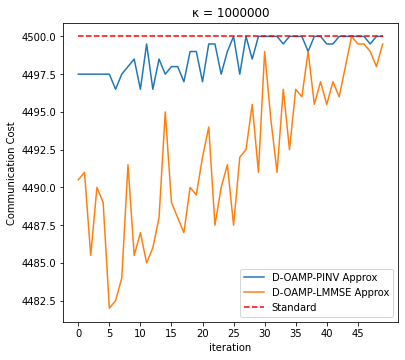

In [44]:
plt.figure(figsize=(6, 5.5))

plt.title('κ = 1000000')
plt.xlabel('iteration')
plt.ylabel('Communication Cost')

plt.xticks(ix2)

plt.plot(it2, mean_CommCost_doamp_approx[0, 12], label='D-OAMP-PINV Approx')
plt.plot(it2, mean_CommCost_doamp_approx[1, 12], label='D-OAMP-LMMSE Approx')
plt.plot(it2, standard, ls='--', color='r', label='Standard')

plt.legend()